<a href="https://colab.research.google.com/github/chengyang122/Metter.js-and-MediaPipe-Interactive-game/blob/main/Detectron2BarcodeX101FPNInference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
torch:  1.11 ; cuda:  cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-f4aw2tz5
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-f4aw2tz5


In [34]:
import numpy as np
import pandas as pd
import cv2
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from tqdm import tqdm
# import some common libraries
import numpy as np
import os, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [35]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("boardetect_train",)
cfg.DATASETS.TEST = ("boardetect_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/barcode/checkpoint/model_9991.pth'  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.DEVICE='cpu'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9 # set the testing threshold for this model
#cfg.DATASETS.TEST = ("boardetect_test", )
predictor = DefaultPredictor(cfg)
print('done')

[05/27 20:26:41 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,8,3,3)         |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [36]:
def collect_predicted(result):
  Object, Mask = result
  useful_index = []
  for i in range(len(Object)):
    score = Object[i]
    if score > 0.6:
      useful_index.append(i)
  rects = []
  predicted_box = []
  predicted_contour = []
  for index in useful_index:
    mg = Mask[index].cpu().numpy().astype(np.uint8)
    contours, hierarchy = cv2.findContours(mg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rect = cv2.minAreaRect(cnt)
    rects.append(rect)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    predicted_box.append(box)
    predicted_contour.append(cnt)
  return predicted_box, predicted_contour, rects

In [37]:
im = cv2.imread('/content/drive/MyDrive/barcode/capture_2018_08_08_05_30_52.png')
outputs = predictor(im)

In [38]:
result = (outputs["instances"].scores, outputs["instances"].pred_masks)
predicted_box, predicted_contour,rects = collect_predicted(result)

In [40]:
def crop_rect(img, rect):
    # get the parameter of the small rectangle
    center, size, angle = rect[0], rect[1], rect[2]
    center, size = tuple(map(int, center)), tuple(map(int, size))

    # get row and col num in img
    height, width = img.shape[0], img.shape[1]

    # calculate the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1)
    # rotate the original image
    img_rot = cv2.warpAffine(img, M, (width, height))

    # now rotated rectangle becomes vertical, and we crop it
    img_crop = cv2.getRectSubPix(img_rot, size, center)
    if img_crop.shape[0]>img_crop.shape[1]:
      img_crop = cv2.rotate(img_crop, cv2.cv2.ROTATE_90_CLOCKWISE)
    return img_crop, img_rot

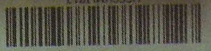

In [41]:
img_crop, img_rot = crop_rect(im, rects[3])
cv2_imshow(img_crop)

In [ ]:
!sudo apt-get install libzbar0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libv4l-0 libv4lconvert0
The following NEW packages will be installed:
  libv4l-0 libv4lconvert0 libzbar0
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 193 kB of archives.
After this operation, 760 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libv4lconvert0 amd64 1.14.2-1 [76.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libv4l-0 amd64 1.14.2-1 [41.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libzbar0 amd64 0.10+doc-10.1build2 [75.7 kB]
Fetched 193 kB in 0s (800 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog

In [ ]:
pip install pyzbar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install zbar


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  ERROR: Failed building wheel for zbar
  Running setup.py clean for zbar
Failed to build zbar
    Running setup.py install for zbar ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ze7_e5c4/zbar_671a18b6cbda4abe9b3a7bd6f9089973/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ze7_e5c4/zbar_671a18b6cbda4abe9b3a7bd6f9089973/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-xh8_3699/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/zbar Check the logs for full command outpu

In [ ]:
import pyzbar.pyzbar as pyzbar
import numpy as np
import cv2

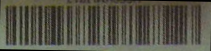

In [101]:
(h, w) = img_crop.shape[:2]
(cX, cY) = (w // 2, h // 2)
M = cv2.getRotationMatrix2D((cX, cY), -1, 1.0)
rotated = cv2.warpAffine(img_crop, M, (w, h))
cv2_imshow(rotated)

In [102]:
resized_image = cv2.resize(rotated, (rotated.shape[1]*3, rotated.shape[0]*3)) 
gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

(153, 633)
12481.492890995261


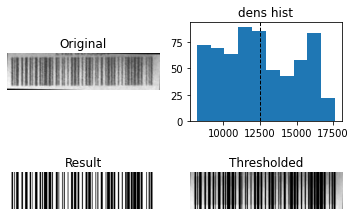

[Decoded(data=b'USCSHMLIB12', type='CODE128', rect=Rect(left=30, top=1, width=0, height=150), polygon=[Point(x=30, y=1), Point(x=30, y=151)], quality=76, orientation=None)]


In [103]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt 
from pyzbar import pyzbar

#------------------------
# Read Image
#========================
img = gray

# #------------------------
# # Morphology
# #========================
# # Closing
# #------------------------
closed = cv.morphologyEx(img, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT, (1, 21)))

# #------------------------
# # Statistics
# #========================
print(img.shape)
dens = np.sum(img, axis=0)
mean = np.mean(dens)
print(mean)

#------------------------
# Thresholding
#========================
thresh = closed.copy()
for idx, val in enumerate(dens):
    if val< mean-500:
        thresh[:,idx] = 0

(_, thresh2) = cv.threshold(thresh, 128, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

#------------------------
# plotting the results
#========================
plt.figure(num='barcode')

plt.subplot(221)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(224)
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded')
plt.axis('off')

plt.subplot(223)
plt.imshow(thresh2, cmap='gray')
plt.title('Result')
plt.axis('off')

plt.subplot(222)
plt.hist(dens)
plt.axvline(dens.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('dens hist')

plt.show()

#------------------------
# Printing the Output
#========================
barcodes = pyzbar.decode(thresh2)
print(barcodes)
